### First attempt at cleaning scheduled rent
The problem is that at random points of time the scheduled rent is either entered for the entire unit, for the actual bed itself.
Moreover sometimes this happens in the middle, sometimes at the start, sometimes at the end \
Other times, the amount is plain wrong (i.e. there are times where a 1bedroom is being charged $3500 for a majority of the time horizon) \
The fastest workaround is to basically apply a ceiling to replace these estimates with something more reasonable (i.e. an average asking price based on bedroom size)

In [ ]:
# import pandas as pd
# import numpy as np
# import os

# # # Rent caps per bedroom count
# # caps = {0: 2000, 1: 2000, 2: 1600, 3: 1500, 4: 1400, 5: 1300, 6: 1200}  # per-bedroom caps
# rent_col = "Scheduled Rent"  # Default column for rent
# # # Function to cap rent based on bedroom count
# # def cap_rent(row):
# #    br = int(row["Bedroom Count"])
# #    r  = row[rent_col]
# #    cap = caps.get(br, np.inf)  # leave untouched if bedroom count not in dict
# #    return min(max(r, 400), cap)

# df = pd.DataFrame()

# # Iterate over all CSV files and fix the scheduled rent so it's actually analyzable
# files = os.listdir("Properties_Cleaned_Rent")
# for file in files:
#     temp_df = pd.read_csv("Properties_Cleaned_Rent/"+file, low_memory=False)

#     temp_df["Scheduled Rent"] = pd.to_numeric(temp_df["Scheduled Rent"], errors="coerce")
#     temp_df["Bedroom Count"]  = pd.to_numeric(temp_df["Bedroom Count"],  errors="coerce")

#     # Drop nulls/zeros and out-of-range bedroom counts
#     temp_df = temp_df[temp_df[rent_col].notna() & (temp_df[rent_col] > 0) & temp_df["Bedroom Count"].notna()]

#     temp_df["Scheduled Rent (Capped)"] = temp_df.apply(cap_rent, axis=1)
#     temp_df.to_csv("Properties_Cleaned_Rent/"+file, index=False)

# df.to_csv("All_Properties_Capped.csv", index=False)

In [39]:
import pandas as pd, numpy as np, re
import os

files = os.listdir("Properties")
for file in files:
    CSV_PATH = "Properties/"+file
    df = pd.read_csv(CSV_PATH, low_memory=False)

    def norm(s): return re.sub(r'[^a-z0-9]+','_', s.lower()).strip('_')
    def to_num(s): return pd.to_numeric(s.astype(str).str.replace(r'[^0-9\.\-]','', regex=True), errors='coerce')

    def find_col(cols, must_any=None, must_all=None, must_not=None, prefer_exact=None):
        nm = {norm(c): c for c in cols}
        cands=[]
        for n, o in nm.items():
            if must_any and not any(k in n for k in must_any): continue
            if must_all and not all(k in n for k in must_all): continue
            if must_not and any(k in n for k in must_not): continue
            cands.append((n,o))
        if prefer_exact:
            for p in prefer_exact:
                if p in dict(cands): return dict(cands)[p]
        if cands:
            cands.sort(key=lambda x: len(x[0]), reverse=True)
            return cands[0][1]
        return None

    market_col   = find_col(df.columns, must_any=["market"], must_all=["rent"], prefer_exact=["market_rent","marketrent"])
    scheduled_col= find_col(df.columns, must_any=["scheduled"], must_all=["rent"], must_not=["market"], prefer_exact=["scheduled_rent","scheduledrent"])
    if scheduled_col is None:
        scheduled_col= find_col(df.columns, must_any=["contract","current","in_place","inplace","actual","lease","rent_amount","asking","ask","rent"],
                                must_all=["rent"], must_not=["market"],
                                prefer_exact=["in_place_rent","contract_rent","current_rent","actual_rent","rent_amount","rent"])
    bed_col      = find_col(df.columns, must_any=["bed"], must_not=["bath"], prefer_exact=["bedrooms","beds","bedroom_count","num_beds"])

    df["_sr"] = to_num(df[scheduled_col])
    df["_mr"] = to_num(df[market_col])
    df["_bd"] = pd.to_numeric(df[bed_col], errors="coerce")

    def learn_threshold(values):
        vals = np.asarray(values, float)
        vals = vals[np.isfinite(vals) & (vals>0)]
        if vals.size < 20: return None
        lo, hi = np.quantile(vals, [0.05, 0.95])
        mid = vals[(vals>=lo) & (vals<=hi)]
        if mid.size < 10: mid = vals
        lv = np.log(mid); lv.sort()
        diffs = np.diff(lv)
        if diffs.size==0: return None
        i = int(np.argmax(diffs))
        if diffs[i] < 0.15: return None
        return float(np.exp((lv[i] + lv[i+1]) / 2.0))

    T = learn_threshold(pd.concat([df["_sr"], df["_mr"]]))
    SIM_TOL = 0.30   # SR/MR ~ 1 tolerance
    RATIO_TOL = 0.35 # SR/MR ~ B or ~1/B tolerance

    def rclose(a,b,tol):
        if not (np.isfinite(a) and np.isfinite(b)): return False
        return abs(a-b)/max(abs(b),1e-9) <= tol

    def standardize_row(sr, mr, b):
        out = {"scheduled_rent_standardized": np.nan, "rule_applied": None, "confidence": 0.0}
        if not (pd.notna(sr) and sr>0): out["rule_applied"]="no_scheduled"; return out
        b_ok = pd.notna(b) and b>0
        mr_ok= pd.notna(mr) and mr>0
        ratio = (sr/mr) if mr_ok else np.nan
        sr_large = (sr >= T) if T is not None else False
        mr_large = (mr >= T) if (T is not None and mr_ok) else None

        # Checks using ratios
        if mr_ok and b_ok:
            if rclose(ratio, 1.0, SIM_TOL):
                if sr_large:
                    out.update(scheduled_rent_standardized=sr, rule_applied="check3_both_unit", confidence=0.85)
                else:
                    out.update(scheduled_rent_standardized=sr*b, rule_applied="check4_both_bed", confidence=0.85)
                return out
            if rclose(ratio, b, RATIO_TOL):
                out.update(scheduled_rent_standardized=sr, rule_applied="check1_sr_unit_mr_bed", confidence=0.95)
                return out
            if rclose(ratio, 1.0/b, RATIO_TOL):
                out.update(scheduled_rent_standardized=sr*b, rule_applied="check2_sr_bed_mr_unit", confidence=0.95)
                return out

        # Fallbacks
        if sr_large or not b_ok:
            out.update(scheduled_rent_standardized=sr, rule_applied="ambiguous_kept_as_unit" if sr_large else "ambiguous_no_bedrooms", confidence=0.65 if sr_large and b_ok else 0.35)
        else:
            out.update(scheduled_rent_standardized=sr*b, rule_applied="ambiguous_scaled_by_beds", confidence=0.65 if b_ok else 0.3)
        return out

    res = df.apply(lambda r: standardize_row(r["_sr"], r["_mr"], r["_bd"]), axis=1, result_type="expand")
    df_out = pd.concat([df, res], axis=1)
    df_out["standardized_rent_per_bed"] = np.where((df_out["scheduled_rent_standardized"].notna()) & (df_out["_bd"]>0),
                                                df_out["scheduled_rent_standardized"]/df_out["_bd"], np.nan)
    output_path = "Properties_Cleaned_Rent/"+file.replace(".csv", "_standardized.csv")
    df_out.to_csv(output_path, index=False)


### Lease Length

Model summary for 17Hundred_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                 1.030e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:46:31   Log-Likelihood:             1.3437e+05
No. Observations:              187344   AIC:                        -2.687e+05
Df Residuals:                  187323   BIC:                        -2.685e+05
Df Model:                          20                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


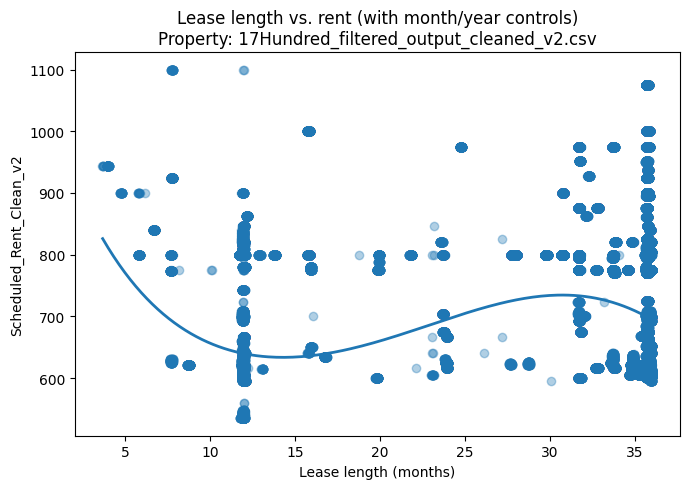

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for 1Eleven_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                 1.560e+04
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:46:34   Log-Likelihood:                -3857.6
No. Observations:               62702   AIC:                             7747.
Df Residuals:                   62686   BIC:                             7892.
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

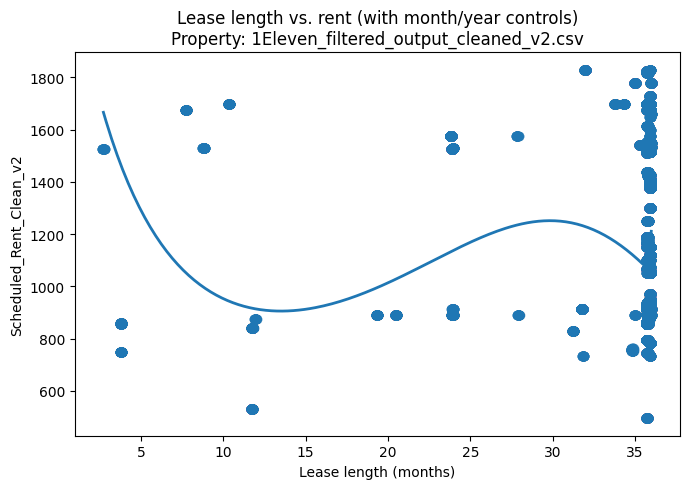

Model summary for 1Ten_on_Whyte_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 2.342e+04
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:46:34   Log-Likelihood:                 3297.6
No. Observations:                8017   AIC:                            -6577.
Df Residuals:                    8008   BIC:                            -6514.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


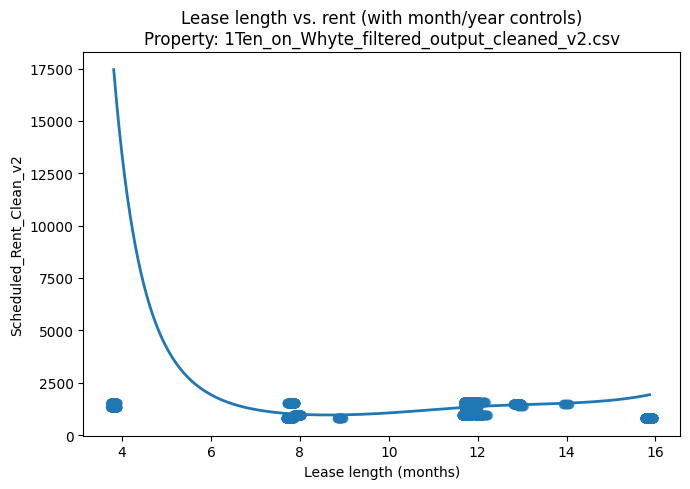

Error processing 308_King_filtered_output_cleaned_v2.csv: index -1 is out of bounds for axis 0 with size 0
Error processing 417Nelson_filtered_output_cleaned_v2.csv: index -1 is out of bounds for axis 0 with size 0
Error processing ALMA_@_ByWard_Market_filtered_output_cleaned_v2.csv: index -1 is out of bounds for axis 0 with size 0


c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 4
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: Deprecati

Model summary for ALMA_@_Guelph_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 1.471e+10
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:46:39   Log-Likelihood:                 14665.
No. Observations:                4322   AIC:                        -2.931e+04
Df Residuals:                    4311   BIC:                        -2.924e+04
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

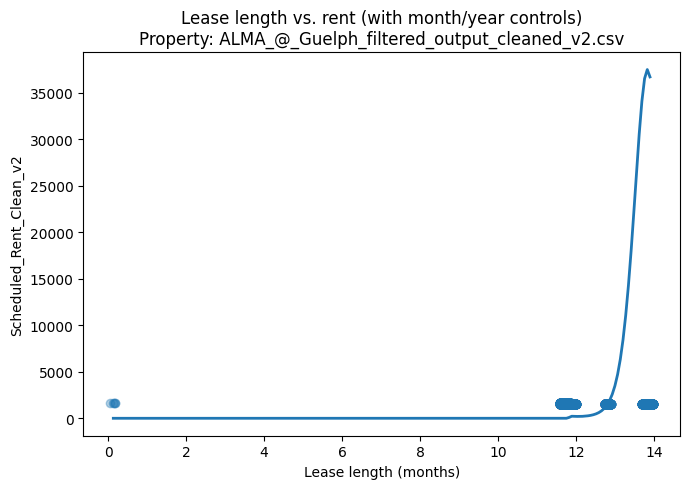

Model summary for ALMA_@_Oshawa_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 3.293e+04
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:46:39   Log-Likelihood:                 2040.8
No. Observations:                1216   AIC:                            -4076.
Df Residuals:                    1213   BIC:                            -4060.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get th

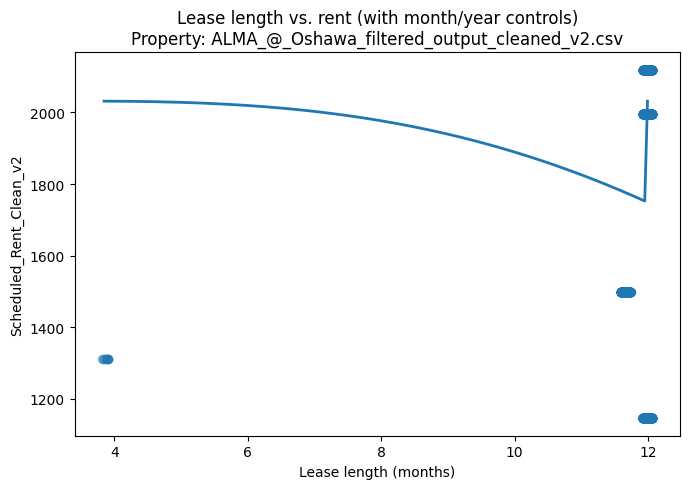

Error processing ALMA_@_Shaughnessy_Village_filtered_output_cleaned_v2.csv: index -1 is out of bounds for axis 0 with size 0
Error processing ALMA_Latin_Quartier_filtered_output_cleaned_v2.csv: index -1 is out of bounds for axis 0 with size 0
Model summary for ALMA_Sandy_Hill_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                     -16.750
Model:                            OLS   Adj. R-squared:                -16.794
Method:                 Least Squares   F-statistic:                  0.003233
Date:                Fri, 22 Aug 2025   Prob (F-statistic):              0.997
Time:                        09:46:40   Log-Likelihood:                 354.77
No. Observations:                1639   AIC:                            -699.5
Df Residuals:                    1634   BIC:                            -672.5
Df Model:                           4                      

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 2
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: Deprecatio

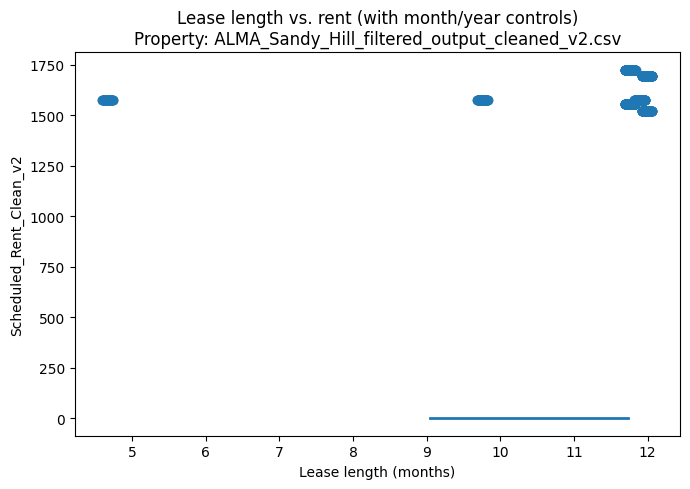

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get 

Model summary for Bridgeport_House_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                 9.860e+09
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:46:43   Log-Likelihood:                -88035.
No. Observations:               93162   AIC:                         1.761e+05
Df Residuals:                   93147   BIC:                         1.762e+05
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------

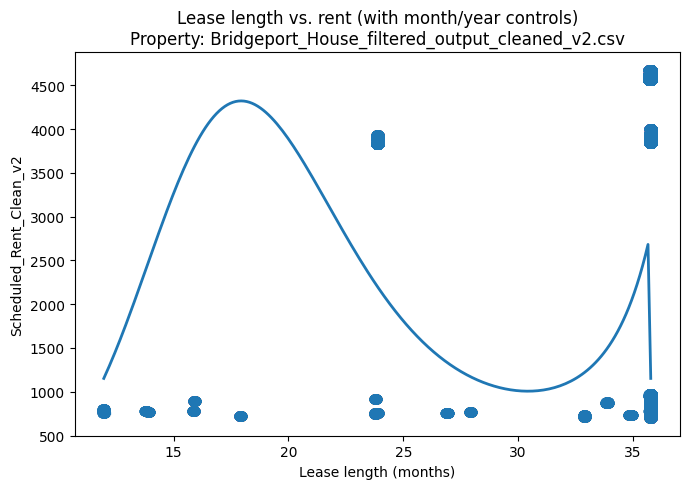

Error processing Fergus_House_filtered_output_cleaned_v2.csv: index -1 is out of bounds for axis 0 with size 0
Error processing Hespeler_House_filtered_output_cleaned_v2.csv: index -1 is out of bounds for axis 0 with size 0
Model summary for King_Street_Towers_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                 5.370e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:46:50   Log-Likelihood:            -1.0748e+05
No. Observations:              144889   AIC:                         2.150e+05
Df Residuals:                  144875   BIC:                         2.151e+05
Df Model:                          13                                      

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


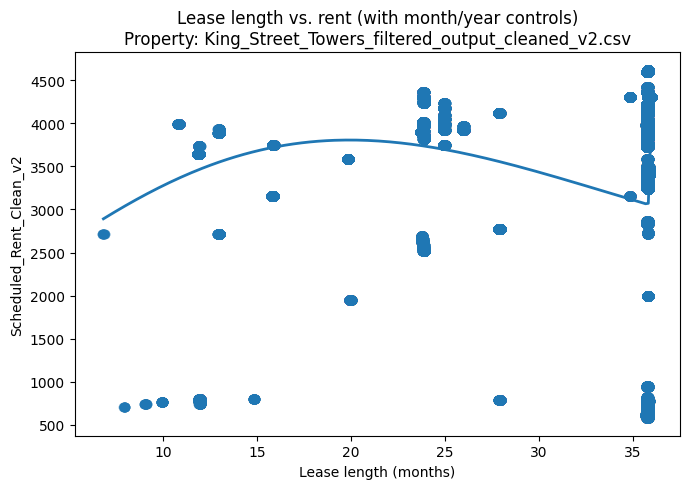

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for MyRez_on_Lester_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                    0.9925
Date:                Fri, 22 Aug 2025   Prob (F-statistic):              0.319
Time:                        09:46:52   Log-Likelihood:                -7874.3
No. Observations:               92640   AIC:                         1.577e+04
Df Residuals:                   92627   BIC:                         1.590e+04
Df Model:                          12                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

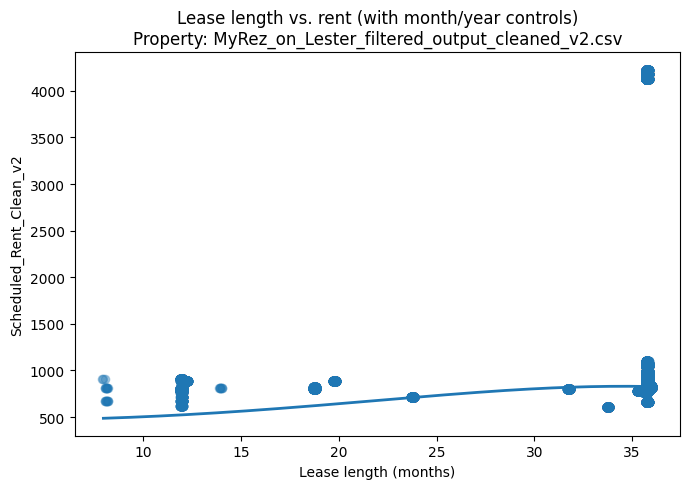

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: Deprecati

Model summary for Preston_House_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                    0.1111
Date:                Fri, 22 Aug 2025   Prob (F-statistic):              0.739
Time:                        09:46:54   Log-Likelihood:                -56405.
No. Observations:               58628   AIC:                         1.128e+05
Df Residuals:                   58617   BIC:                         1.129e+05
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

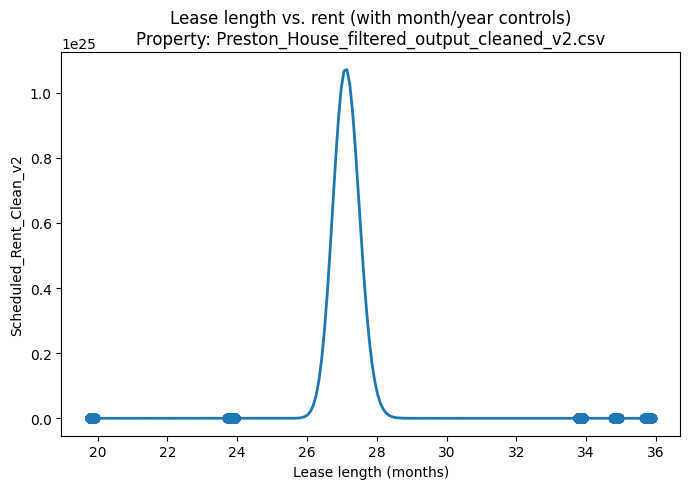

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 10
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for See-More_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                 2.351e+04
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:46:59   Log-Likelihood:                 17993.
No. Observations:              292527   AIC:                        -3.596e+04
Df Residuals:                  292513   BIC:                        -3.581e+04
Df Model:                          13                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

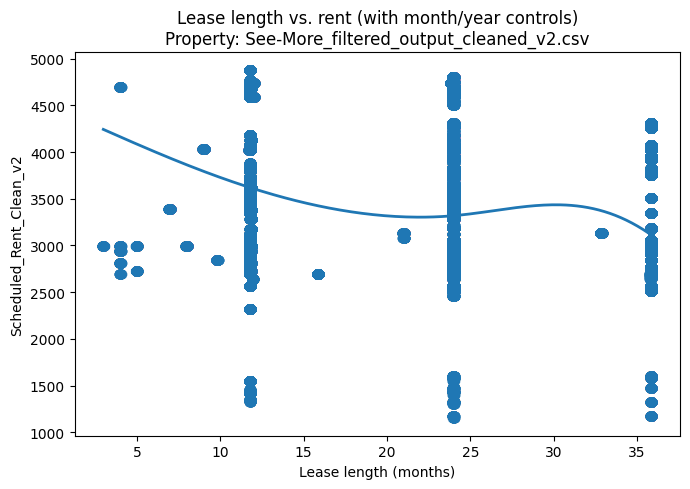

Model summary for The_Arc_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     3670.
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:47:02   Log-Likelihood:                 25395.
No. Observations:               57411   AIC:                        -5.075e+04
Df Residuals:                   57393   BIC:                        -5.059e+04
Df Model:                          17                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


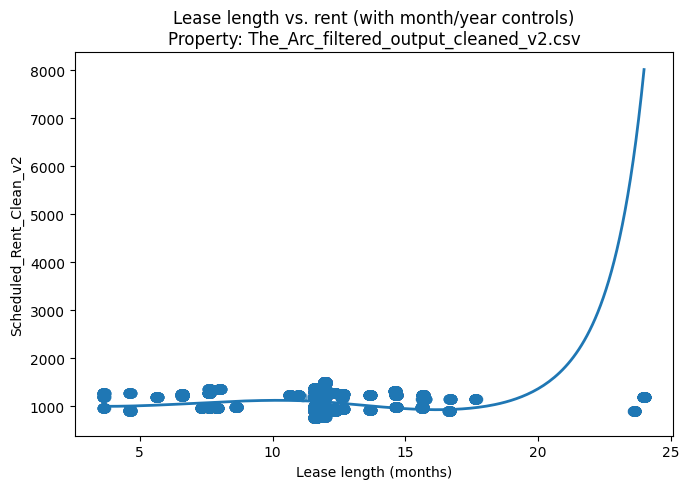

Model summary for The_Quad_at_York_Phase_1_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                 4.257e+07
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:47:04   Log-Likelihood:                 15700.
No. Observations:               15455   AIC:                        -3.137e+04
Df Residuals:                   15440   BIC:                        -3.126e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


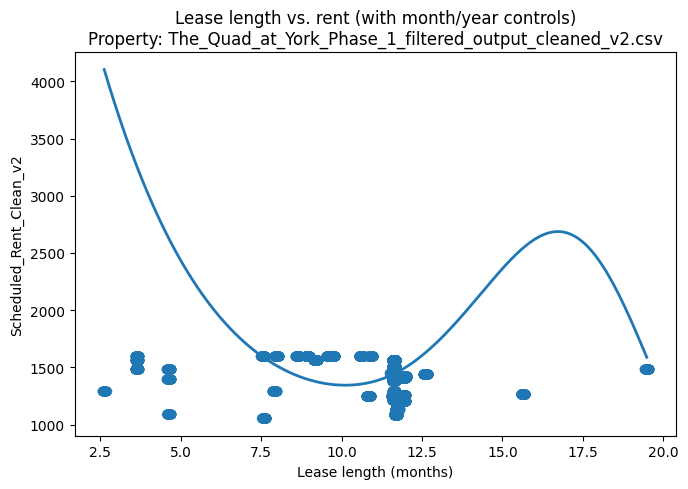

Model summary for The_Quad_at_York_Phase_2_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                   -1173.791
Model:                            OLS   Adj. R-squared:              -1176.995
Method:                 Least Squares   F-statistic:                 2.921e-05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               1.00
Time:                        09:47:07   Log-Likelihood:                -2200.7
No. Observations:                1839   AIC:                             4413.
Df Residuals:                    1833   BIC:                             4446.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 4
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: Deprecatio

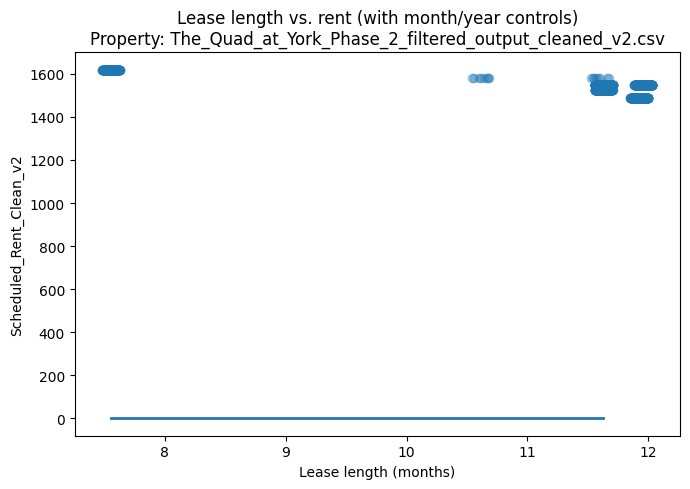

c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 14
  warnings.warn('covariance of constraints does not have full '
c:\Users\JackE\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\JackE\AppData\Local\Temp\ipykernel_13340\523027827.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "F": float(wald.fvalue),


Model summary for West_Village_Suites_filtered_output_cleaned_v2.csv:
                            OLS Regression Results                            
Dep. Variable:               log_rent   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                 1.430e+05
Date:                Fri, 22 Aug 2025   Prob (F-statistic):               0.00
Time:                        09:47:08   Log-Likelihood:                 6282.5
No. Observations:               17246   AIC:                        -1.253e+04
Df Residuals:                   17230   BIC:                        -1.241e+04
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------

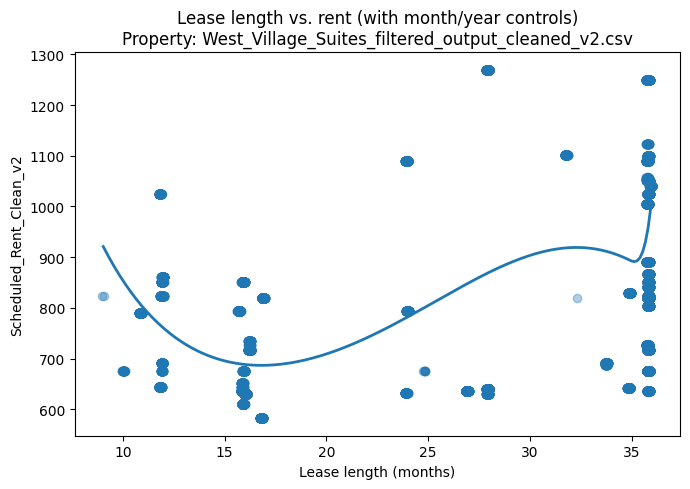

Error processing Woodroffe_Place_filtered_output_cleaned_v2.csv: index -1 is out of bounds for axis 0 with size 0


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
# Read all cleaned files
files = os.listdir("Properties_Cleaned_Rent")
for file in files:
    # Read property
    temp_df = pd.read_csv("Properties_Cleaned_Rent/"+file, low_memory=False)
    temp_df["Lease Start Date"] = pd.to_datetime(temp_df["Lease Start Date"], errors="coerce")
    temp_df["Lease End Date"] = pd.to_datetime(temp_df["Lease End Date"], errors="coerce")

    # Calculate lease length in months (note 365.25/ 12 = 30.4375 days per month)
    temp_df["Lease Length"] = (temp_df["Lease End Date"] - temp_df["Lease Start Date"]).dt.days / 30.4375

    temp_df["Lease Start Year"] = temp_df["Lease Start Date"].dt.year
    temp_df["Lease Start Month"] = temp_df["Lease Start Date"].dt.month

    temp_df["Scheduled_Rent_Clean_v2"] = pd.to_numeric(temp_df["Scheduled_Rent_Clean_v2"], errors="coerce")
    
    # Filter out rows with invalid lease lengths or rents
    temp_df = temp_df[(temp_df["Lease Length"].notna()) & (temp_df["Scheduled_Rent_Clean_v2"] > 0)]
    temp_df = temp_df[(temp_df["Lease Length"] > 0) & (temp_df["Lease Length"] <= 36)]  # reasonable lease lengths (1-36 months)
    temp_df = temp_df[temp_df["Lease Start Month"].notna() & temp_df["Lease Start Year"].notna()]

    # Columns to keep
    cols_keep = ['Unit Space ID', 'Lease Start Date', 'Lease End Date', 'Lease Length', 'Lease Start Year', 'Lease Start Month', 'Scheduled_Rent_Clean_v2']
    temp_df = temp_df[cols_keep].dropna()
    
    # Log transform and rename columns
    temp_df["Log Scheduled Rent"] = np.log(temp_df["Scheduled_Rent_Clean_v2"])
    temp_df = temp_df.rename(columns={
        "Log Scheduled Rent": "log_rent",
        "Lease Length": "lease_length",
        "Lease Start Month": "start_month",
        "Lease Start Year": "start_year"
    })

    formula = "log_rent ~ bs(lease_length, df=4, include_intercept=False) + C(start_month) + C(start_year)"
    try:
        model = smf.ols(formula=formula, data=temp_df).fit(cov_type="HC1")
        print(f"Model summary for {file}:\n{model.summary()}\n")

        exog_names = model.model.exog_names
        bs_cols = [i for i, name in enumerate(exog_names) if name.startswith("bs(lease_length")]
        R = np.zeros((len(bs_cols), len(exog_names)))
        for r_i, col_idx in enumerate(bs_cols):
            R[r_i, col_idx] = 1.0
        wald = model.wald_test(R, use_f=True)
        wald_test_results = {
            "F": float(wald.fvalue),
            "df_num": int(wald.df_num),
            "df_denom": int(wald.df_denom),
            "p_value": float(wald.pvalue)
        }

        # Coefficient table
        coef_table = model.summary2().tables[1].reset_index().rename(columns={"index":"term"})
        x_grid = np.linspace(temp_df['lease_length'].min(), temp_df['lease_length'].max(), 200)
        # Build a frame holding typical month/year (use modal month/year)
        modal_month = int(temp_df['start_month'].mode().iloc[0])
        modal_year = int(temp_df['start_year'].mode().iloc[0])
        pred_df = pd.DataFrame({
            "lease_length": x_grid,
            "start_month": modal_month,
        "start_year": modal_year
        })
        pred_log = model.predict(pred_df)
        pred = np.exp(pred_log)

        # Plot
        plt.figure(figsize=(7,5))
        # scatter of observed (jittered)
        jitter = (np.random.rand(len(temp_df)) - 0.5) * 0.15
        plt.scatter(temp_df['lease_length'] + jitter, temp_df['Scheduled_Rent_Clean_v2'], alpha=0.35)
        plt.plot(x_grid, pred, linewidth=2)
        plt.xlabel("Lease length (months)")
        plt.ylabel("Scheduled_Rent_Clean_v2")
        plt.title(f"Lease length vs. rent (with month/year controls)\nProperty: {file}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing {file}: {e}")


    

In [40]:
GoogleReviewStars = {
    "17Hundred": 3.5,
    "1Eleven": 3.8,
    "1Ten_on_Whyte": 4.2, 
    "308_King": 4.7,
    "417Nelson": 4.9,
    "ALMA_@_ByWard_Market": 4.0,  
    "ALMA_@_Guelph": 4.6,
    "ALMA_@_Oshawa": 3.8,
    "ALMA_@_Shaughnessy_Village": 3.8,
    "ALMA_Latin_Quartier": 5.0,
    "ALMA_Sandy_Hill": 4.2,
    "Bridgeport_House": 3.9,
    "Fergus_House": 4.1,
    "Hespeler_House": 4.0,
    "King_Street_Towers": 3.9,
    "MyRez_on_Lester": 4.1,
    "Preston_House": 4.0,
    "See-More": 4.7,
    "The_Arc": 4.0,
    "The_Quad_at_York_Phase_1": 3.6, 
    "The_Quad_at_York_Phase_2": 3.6,
    "West_Village_Suites": 3.1,
    "Woodroffe_Place": 3.9
}

In [43]:
files = os.listdir("Properties_Cleaned_Rent")

results = []
for file in files:
    temp_df = pd.read_csv("Properties_Cleaned_Rent/"+file, low_memory=False)
    
    # Convert dates
    # temp_df["Event Date"] = pd.to_datetime(temp_df["Event Date"], errors="coerce")
    
    # Add Google review stars
    property_name = file.replace("_filtered_output_standardized", "").split('.')[0]
    
    # # Only use current users for rental income
    # temp_df = temp_df[temp_df["Unit Status"].isin(["Occupied No Notice", "Notice Unrented", "Notice Rented"])]
    # temp_df = temp_df[temp_df["Scheduled_Rent_Clean_v2"].notna() & (temp_df["Scheduled_Rent_Clean_v2"] > 0)]
    # # Group by date
    # daily_summary = temp_df.groupby('Event Date').agg(
    #     total_revenue=('Scheduled_Rent_Clean_v2', 'sum'),
    #     all_units=('Unit Status', 'count')  # count of rows/units per day
    # )
    # daily_summary['AverageRevenue'] = daily_summary['total_revenue'] / daily_summary['all_units']

    # avg_revenue_property = daily_summary['AverageRevenue'].mean()
    avg_revenue_property = temp_df["standardized_rent_per_bed"].mean()
    results.append({
        "PropertyName": property_name,
        "AvgRevenue": avg_revenue_property,
        "GoogleReviewStars": GoogleReviewStars.get(property_name, None)
    })

property_summary = pd.DataFrame(results)
property_summary = property_summary[property_summary["AvgRevenue"].notna()]
property_summary

,PropertyName,AvgRevenue,GoogleReviewStars
0,17Hundred,779.145900,3.5
1,1Eleven,1263.601203,3.8
2,1Ten_on_Whyte,879.374550,4.2
3,308_King,1274.358720,4.7
4,417Nelson,1301.105451,4.9
5,ALMA_@_ByWard_Market,1760.542739,4.0
6,ALMA_@_Guelph,1558.540953,4.6
7,ALMA_@_Oshawa,1508.729685,3.8
8,ALMA_@_Shaughnessy_Village,1408.585573,3.8
9,ALMA_Latin_Quartier,2133.702047,5.0


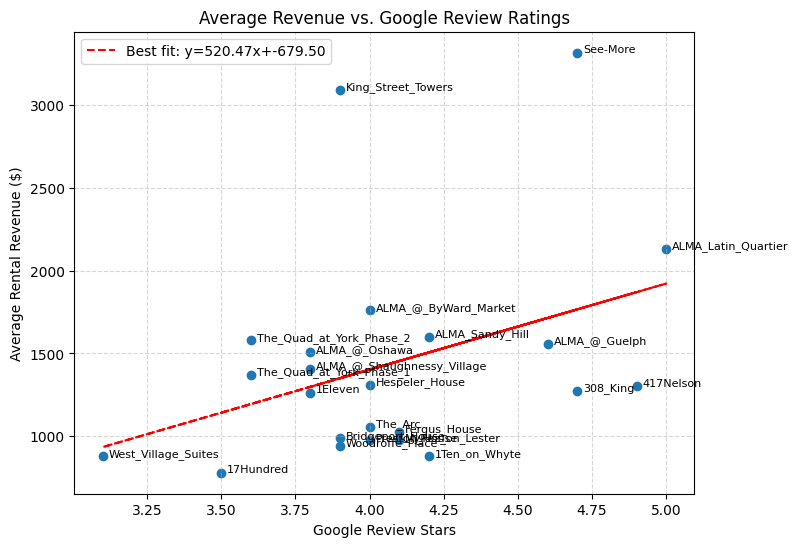

In [44]:

plt.figure(figsize=(8,6))
plt.scatter(property_summary["GoogleReviewStars"], property_summary["AvgRevenue"])

# Labels
for i, row in property_summary.iterrows():
    plt.text(row["GoogleReviewStars"]+0.02, row["AvgRevenue"], row["PropertyName"], fontsize=8)

# Best-fit line
x = property_summary["GoogleReviewStars"]
y = property_summary["AvgRevenue"]

# Fit a straight line (degree=1 polynomial)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="red", linestyle="--", label=f"Best fit: y={m:.2f}x+{b:.2f}")

plt.xlabel("Google Review Stars")
plt.ylabel("Average Rental Revenue ($)")
plt.title("Average Revenue vs. Google Review Ratings")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


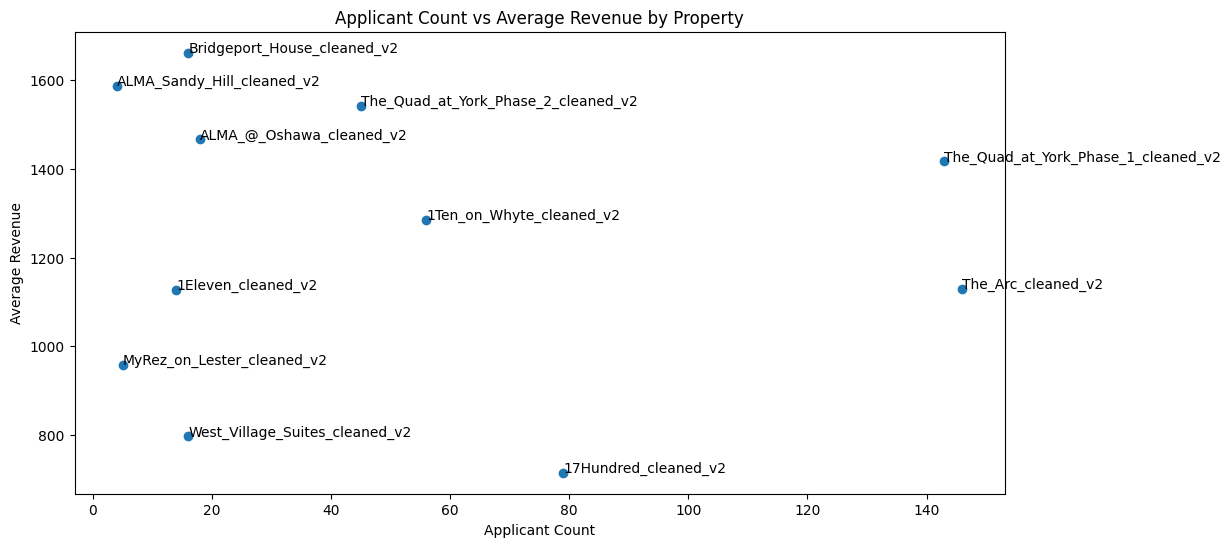

In [29]:
# Replace spaces with underscores in the property column
currentApplicantsdf = pd.read_csv("Current Applicants.csv")
currentApplicantsdf["Property"] = currentApplicantsdf["Property"].str.replace(" ", "_")


# Now count again
property_counts = currentApplicantsdf["Property"].value_counts()


property_counts_df = property_counts.reset_index()
property_counts_df.columns = ["PropertyName", "ApplicantCount"]
property_counts_df["PropertyName"] = property_counts_df["PropertyName"].astype(str) + "_cleaned_v2"
merged_df = pd.merge(property_counts_df, property_summary, on="PropertyName", how="left")

plt.figure(figsize=(12,6))
plt.scatter(merged_df["ApplicantCount"], merged_df["AvgRevenue"])

for i, txt in enumerate(merged_df["PropertyName"]):
    plt.annotate(txt, (merged_df["ApplicantCount"].iloc[i], merged_df["AvgRevenue"].iloc[i]))

plt.xlabel("Applicant Count")
plt.ylabel("Average Revenue")
plt.title("Applicant Count vs Average Revenue by Property")
plt.show()

In [ ]:
floors_per_building = {
    "17Hundred": 10, # divided up into 6 storeys and 4 storeys
    "1Eleven": 16,
    "1Ten_on_Whyte": 4,
    "308_King": 25,
    "417Nelson": 31,
    "ALMA_@_ByWard_Market": 15,
    "ALMA_@_Guelph": 7, # Two 7-storey buildings
    "ALMA_@_Oshawa": 9,
    "ALMA_@_Shaughnessy_Village": 18,
    "ALMA_Latin_Quartier": 3,
    "ALMA_Sandy_Hill": 6,
    "Bridgeport_House": 18,
    "Fergus_House": 21,
    "Hespeler_House": 21,
    "King_Street_Towers": 38, # two towers - one with 17 floors and one with 21 floors
    "MyRez_on_Lester": 18,
    "Preston_House": 17,
    "See-More": 16,
    "The_Arc": 15,
    "The_Quad_at_York_Phase_1": 7,
    "The_Quad_at_York_Phase_2": 6,
    "West_Village_Suites": 9,
    "Woodroffe_Place": 16
}

In [ ]:
building_counts = []
files = os.listdir("Properties")
for file in files:
    df_temp = pd.read_csv("Properties/"+file)
    df_temp = df_temp[df_temp["Scheduled Rent"] >= 0].dropna(subset=["Unit Space ID"])
    unique_amt = df_temp["Unit Space ID"].nunique()
    avg_rent = df_temp["Scheduled Rent"].mean()
    building_name = os.path.basename(file).replace("_filtered_output.csv", "")
    floors = floors_per_building[building_name]
    avg_units_per_floor = unique_amt / floors
    building_counts.append({"Building": building_name, "Count": unique_amt, "Floors": floors, "AvgRent": avg_rent, "Average Units Per Floor": avg_units_per_floor})

building_counts_df = pd.DataFrame(building_counts)
building_counts_df